# Admissible Property Set — Geometric Construction

## Setup

| Space | Type | Element |
|---|---|---|
| Model space $\mathcal{M} = \mathbb{R}^2$ | `EuclideanSpace(2)` | $m = (m_1, m_2)$ |
| Data space $\mathcal{D} = \mathbb{R}$ | `EuclideanSpace(1)` | $d \in \mathbb{R}$ |
| Property space $\mathcal{P} = \mathbb{R}$ | `EuclideanSpace(1)` | $p \in \mathbb{R}$ |

**Forward operator:** $G(m) = m_1 + m_2$ (matrix $[1,\ 1]$).  
Kernel: $\ker G = \{(t, -t) : t \in \mathbb{R}\}$ — the anti-diagonal line $m_2 = -m_1$.  
Fibers: $\mathcal{F}_{d^*} = \{m : m_1 + m_2 = d^*\}$ — lines parallel to the kernel.

**Property operator:** $T(m) = m_1$ (matrix $[1,\ 0]$).

**Prior set:** $\mathcal{B} = \{m : \|m\|_2 \le r_M\}$ (disk in $\mathbb{R}^2$).

**Noise set:** $\mathcal{V} = [-r_V, r_V] \subset \mathbb{R}$ (interval).

**Admissible property set:**
$$\mathcal{U} = T\bigl(\mathcal{B}\cap G^{-1}(\tilde{d} - \mathcal{V})\bigr)
= \bigcup_{d^* \in \tilde{d}-\mathcal{V}} T\bigl(\mathcal{F}_{d^*} \cap \mathcal{B}\bigr)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.collections import PatchCollection
import warnings
import pathlib

from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.linear_operators import LinearOperator

print('imports OK ✓')

imports OK ✓


## Spaces and operators

In [2]:
# ── Spaces ────────────────────────────────────────────────────────────────
M = EuclideanSpace(2)   # model space  ℝ²
D = EuclideanSpace(1)   # data space   ℝ
P = EuclideanSpace(1)   # property space ℝ

# ── Forward operator G: ℝ² → ℝ,  G(m) = m₁ + m₂ ──────────────────────────
G_mat = np.array([[1.0, 1.0]])   # shape (1, 2)
G = LinearOperator(
    M, D,
    lambda m: G_mat @ m,
    adjoint_mapping=lambda lam: G_mat.T @ lam,
)

# ── Property operator T: ℝ² → ℝ,  T(m) = m₁ ──────────────────────────────
T_mat = np.array([[1.0, 0.0]])   # shape (1, 2)
T = LinearOperator(
    M, P,
    lambda m: T_mat @ m,
    adjoint_mapping=lambda q: T_mat.T @ q,
)

# ── Parameters ─────────────────────────────────────────────────────────────
r_M     = 2.0    # prior ball radius in ℝ²
r_V     = 0.8    # noise radius in ℝ  (half-width of V = [-r_V, r_V])
d_tilde = 0.6    # observed data (∈ ℝ)

# Range of 'possible true data' = d̃ − V = [d̃ − r_V, d̃ + r_V]
d_lo = d_tilde - r_V
d_hi = d_tilde + r_V

print(f"Forward kernel: ker G = {{(t, -t)}}  (anti-diagonal line m₂ = -m₁)")
print(f"Prior ball radius: r_M = {r_M}  →  fiber intersects ball when |d*| ≤ {r_M*np.sqrt(2):.3f}")
print(f"Noise interval: V = [{-r_V}, {r_V}]")
print(f"Possible true data: d* ∈ [{d_lo:.2f}, {d_hi:.2f}]")


Forward kernel: ker G = {(t, -t)}  (anti-diagonal line m₂ = -m₁)
Prior ball radius: r_M = 2.0  →  fiber intersects ball when |d*| ≤ 2.828
Noise interval: V = [-0.8, 0.8]
Possible true data: d* ∈ [-0.20, 1.40]


## Closed-form geometry

For a fixed $d^* \in \mathbb{R}$, the **fiber** is $\mathcal{F}_{d^*} = \{(m_1, d^*-m_1)\}$.  
Its intersection with the ball $\{\|m\|\le r_M\}$ exists when $|d^*|/\sqrt{2} \le r_M$, giving:

$$\mathcal{F}_{d^*} \cap \mathcal{B}
= \left\{\!\left(m_1,\; d^*-m_1\right) : m_1 \in \left[\tfrac{d^*}{2} - \delta,\; \tfrac{d^*}{2} + \delta\right]\right\},
\quad \delta = \sqrt{r_M^2 - \tfrac{d^{*2}}{2}}$$

Since $T(m) = m_1$, the image under $T$ is exactly the interval for $m_1$:
$$T(\mathcal{F}_{d^*}\cap\mathcal{B}) = \left[\tfrac{d^*}{2}-\delta,\; \tfrac{d^*}{2}+\delta\right].$$

In [15]:
def fiber_chord(d_star, r_M):
    """Chord endpoints (m1, m2) of the fiber ∩ ball, or None.

    Derivation: m1² + (d*-m1)² = r_M²  →  2(m1 - d*/2)² = r_M² - d*²/2
    so  δ = sqrt((r_M² - d*²/2) / 2),  m1 = d*/2 ± δ.
    """
    half_disc = r_M**2 / 2.0 - d_star**2 / 4.0   # = (r_M² - d*²/2) / 2
    if half_disc < 0:
        return None
    delta = np.sqrt(half_disc)
    m1_lo, m1_hi = d_star / 2 - delta, d_star / 2 + delta
    # chord: from (m1_lo, d*-m1_lo) to (m1_hi, d*-m1_hi)
    return np.array([[m1_lo, d_star - m1_lo],
                     [m1_hi, d_star - m1_hi]])

def prop_interval(d_star, r_M):
    """Property interval [p_lo, p_hi] = T(fiber ∩ ball), or None."""
    chord = fiber_chord(d_star, r_M)
    if chord is None:
        return None
    # T(m) = m1, so property = first column of chord
    return (chord[:, 0].min(), chord[:, 0].max())

# Verify at d* = d̃ (centre)
ch = fiber_chord(d_tilde, r_M)
pi = prop_interval(d_tilde, r_M)
norms = np.linalg.norm(ch, axis=1)
print(f"At d* = d̃ = {d_tilde}:")
print(f"  Chord endpoints: {ch}")
print(f"  Endpoint norms (should both equal {r_M}): {norms}")
print(f"  Property interval: [{pi[0]:.4f}, {pi[1]:.4f}]")
print(f"  Centre m1 = {d_tilde/2:.4f},  half-width δ = {np.sqrt(r_M**2/2 - d_tilde**2/4):.4f}")


At d* = d̃ = 0.6:
  Chord endpoints: [[-1.0820275  1.6820275]
 [ 1.6820275 -1.0820275]]
  Endpoint norms (should both equal 2.0): [2. 2.]
  Property interval: [-1.0820, 1.6820]
  Centre m1 = 0.3000,  half-width δ = 1.3820


In [16]:
# Pre-compute all frames
N_HALF   = 90          # frames for one sweep direction
N_FRAMES = 2 * N_HALF  # total: forward then back

t_fwd    = np.linspace(d_lo, d_hi, N_HALF)
t_bwd    = np.linspace(d_hi, d_lo, N_HALF)
d_values = np.concatenate([t_fwd, t_bwd])

# Property intervals for each frame
p_lo_all = np.full(N_FRAMES, np.nan)
p_hi_all = np.full(N_FRAMES, np.nan)
for k, d in enumerate(d_values):
    iv = prop_interval(d, r_M)
    if iv is not None:
        p_lo_all[k], p_hi_all[k] = iv

# Cumulative union: the 'painted' region up to frame k
cum_lo  = np.minimum.accumulate(p_lo_all)
cum_hi  = np.maximum.accumulate(p_hi_all)

# Absolute admissible interval (full video)
U_lo = np.nanmin(p_lo_all)
U_hi = np.nanmax(p_hi_all)

print(f"Property range over all d*: U = [{U_lo:.4f}, {U_hi:.4f}]")
print(f"Number of frames: {N_FRAMES}")

Property range over all d*: U = [-1.5107, 1.9288]
Number of frames: 180


## Static preview — single frame at $d^* = \tilde{d}$

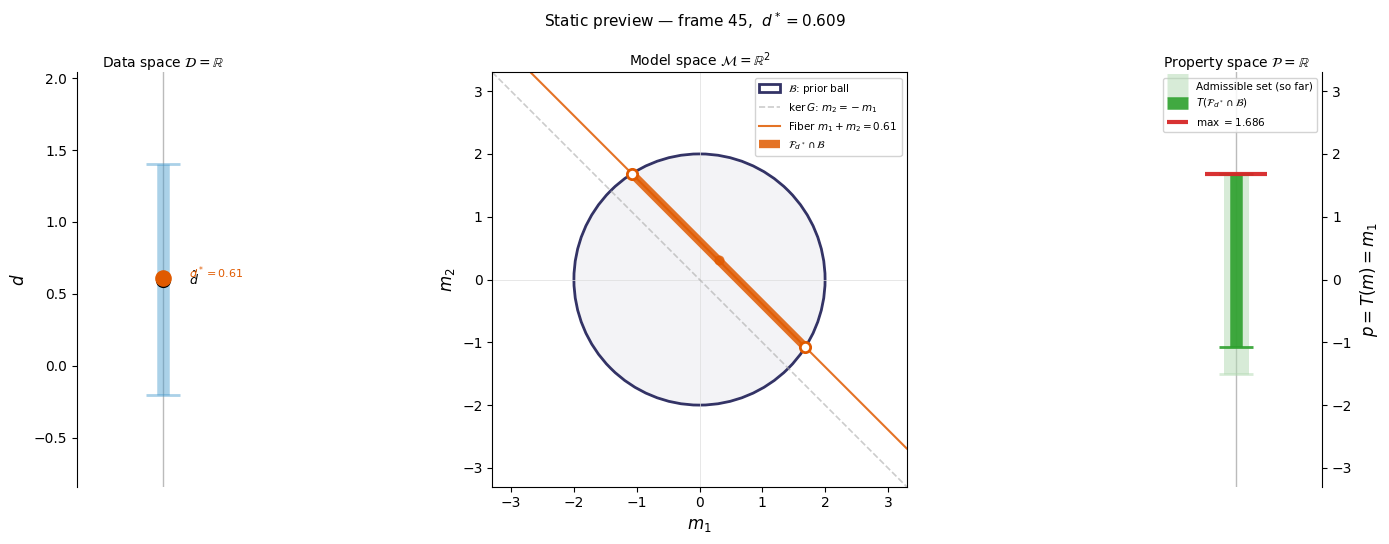

Preview OK ✓


In [17]:
%matplotlib inline

# ── Colour scheme ──────────────────────────────────────────────────────────
C_NOISE   = '#4499CC'   # noise interval
C_FIBER   = '#E05A00'   # current fiber line
C_CHORD   = '#E05A00'   # chord (intersection)
C_PROP    = '#2CA02C'   # property interval
C_UNION   = '#B0D9B0'   # cumulative union (light green)
C_MAX     = '#D62728'   # running-max marker
C_KERNEL  = '#AAAAAA'   # kernel line (faint)
C_BALL    = '#333366'   # prior ball edge

L = 3.3        # axis half-extent for model space
P_LIM = 3.3    # axis limit for property space
D_LIM_LO = d_tilde - 1.8 * r_V
D_LIM_HI = d_tilde + 1.8 * r_V

# Width of the thick number-line segments (in points)
LW_SEGMENT  = 9    # fat coloured bar
LW_TICK     = 2    # endpoint ticks
TICK_HALF   = 0.12 # half-width of tick marks in data coordinates

def _number_line_setup(ax, ylim_lo, ylim_hi, title, ylabel, ylabel_right=False):
    """Configure an axis as a clean 1-D number line."""
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(ylim_lo, ylim_hi)
    ax.set_xticks([])
    ax.set_title(title, fontsize=10, pad=4)
    ax.set_ylabel(ylabel, fontsize=12)
    if ylabel_right:
        ax.yaxis.set_label_position('right')
        ax.yaxis.tick_right()
        ax.spines[['top', 'left', 'bottom']].set_visible(False)
    else:
        ax.spines[['top', 'right', 'bottom']].set_visible(False)
    # Draw the number-line axis
    ax.plot([0, 0], [ylim_lo, ylim_hi], color='#BBBBBB', lw=1, zorder=1)

def _segment(ax, y_lo, y_hi, color, lw, alpha, zorder, label=None):
    """Draw a thick vertical segment on the number line (x=0)."""
    ax.plot([0, 0], [y_lo, y_hi], color=color, lw=lw,
            solid_capstyle='butt', alpha=alpha, zorder=zorder,
            label=label if label else '_nolegend_')
    # Endpoint ticks
    ax.hlines([y_lo, y_hi], -TICK_HALF, TICK_HALF,
              colors=color, lw=LW_TICK, alpha=alpha, zorder=zorder + 0.5)

def draw_frame(ax_d, ax_m, ax_p, frame_idx):
    """Draw all three panels for a given frame."""
    d_star  = d_values[frame_idx]
    p_lo_k  = p_lo_all[frame_idx]
    p_hi_k  = p_hi_all[frame_idx]
    c_lo    = cum_lo[frame_idx]
    c_hi    = cum_hi[frame_idx]
    chord   = fiber_chord(d_star, r_M)

    # ── Panel 1: Data space ℝ ─────────────────────────────────────────────
    _number_line_setup(ax_d, D_LIM_LO, D_LIM_HI,
                       title=r'Data space $\mathcal{D}=\mathbb{R}$',
                       ylabel='$d$')

    # Noise interval (thick blue segment)
    _segment(ax_d, d_lo, d_hi, C_NOISE, lw=LW_SEGMENT, alpha=0.45, zorder=2,
             label=r'$\tilde{d} - \mathcal{V}$')

    # Observed d̃  (hollow dot)
    ax_d.scatter([0], [d_tilde], color='white', edgecolors='k', s=80,
                 zorder=6, linewidths=2)
    ax_d.annotate(r'$\tilde{d}$', xy=(0, d_tilde),
                  xytext=(0.18, d_tilde), fontsize=9, va='center')

    # Current d*  (filled dot)
    ax_d.scatter([0], [d_star], color=C_FIBER, s=120, zorder=7)
    ax_d.annotate(f'$d^*={d_star:.2f}$', xy=(0, d_star),
                  xytext=(0.18, d_star + 0.04),
                  fontsize=8, color=C_FIBER, va='center',
                  annotation_clip=False)

    # ── Panel 2: Model space ℝ² ────────────────────────────────────────────
    ax_m.set_xlim(-L, L)
    ax_m.set_ylim(-L, L)
    ax_m.set_aspect('equal')
    ax_m.set_xlabel('$m_1$', fontsize=12)
    ax_m.set_ylabel('$m_2$', fontsize=12)
    ax_m.set_title(r'Model space $\mathcal{M}=\mathbb{R}^2$', fontsize=10, pad=4)
    ax_m.axhline(0, color='#DDDDDD', lw=0.5)
    ax_m.axvline(0, color='#DDDDDD', lw=0.5)

    # Prior ball
    ax_m.add_patch(plt.Circle((0, 0), r_M, color=C_BALL, fill=False, lw=2,
                               label=r'$\mathcal{B}$: prior ball'))
    ax_m.add_patch(plt.Circle((0, 0), r_M, color=C_BALL, alpha=0.06))

    # Kernel line  m2 = -m1  (faint)
    m1_line = np.array([-L, L])
    ax_m.plot(m1_line, -m1_line, '--', color=C_KERNEL, lw=1.2, alpha=0.6,
              label=r'$\ker G$: $m_2=-m_1$')

    # Current fiber line  m2 = d* - m1
    ax_m.plot(m1_line, d_star - m1_line, '-', color=C_FIBER, lw=1.5, alpha=0.85,
              label=fr'Fiber $m_1+m_2={d_star:.2f}$')

    ax_m.scatter([d_star/2], [d_star/2], color=C_FIBER, s=40, zorder=5, alpha=0.7)

    # Chord (fiber ∩ ball) — butt caps so the line ends exactly at the math endpoints
    if chord is not None:
        ax_m.plot(chord[:, 0], chord[:, 1], '-', color=C_CHORD, lw=6,
                  alpha=0.85, solid_capstyle='butt',
                  label=r'$\mathcal{F}_{d^*}\cap\mathcal{B}$')
        ax_m.scatter(chord[:, 0], chord[:, 1], color='white',
                     edgecolors=C_CHORD, s=55, zorder=8, linewidths=2)

    ax_m.legend(fontsize=7.5, loc='upper right', framealpha=0.85)

    # ── Panel 3: Property space ℝ ─────────────────────────────────────────
    _number_line_setup(ax_p, -P_LIM, P_LIM,
                       title=r'Property space $\mathcal{P}=\mathbb{R}$',
                       ylabel='$p = T(m) = m_1$',
                       ylabel_right=True)

    # Cumulative union (light green, wide segment)
    if not np.isnan(c_lo) and not np.isnan(c_hi):
        _segment(ax_p, c_lo, c_hi, C_UNION, lw=LW_SEGMENT * 2, alpha=0.50,
                 zorder=2, label='Admissible set (so far)')

    # Current property interval (darker green, narrower)
    if not np.isnan(p_lo_k) and not np.isnan(p_hi_k):
        _segment(ax_p, p_lo_k, p_hi_k, C_PROP, lw=LW_SEGMENT, alpha=0.90,
                 zorder=3, label=r'$T(\mathcal{F}_{d^*}\cap\mathcal{B})$')

    # Running maximum (short horizontal tick in red)
    if not np.isnan(c_hi):
        ax_p.hlines(c_hi, -TICK_HALF * 1.8, TICK_HALF * 1.8,
                    colors=C_MAX, lw=3, alpha=0.95, zorder=5,
                    label=fr'max $= {c_hi:.3f}$')

    ax_p.legend(fontsize=7.5, loc='upper right', framealpha=0.85)

# ── Draw preview ──────────────────────────────────────────────────────────
preview_frame = N_HALF // 2   # middle of forward sweep

fig_prev, axes_prev = plt.subplots(1, 3, figsize=(14, 5.5),
                                    gridspec_kw={'width_ratios': [0.5, 3, 0.5]})
draw_frame(axes_prev[0], axes_prev[1], axes_prev[2], preview_frame)
fig_prev.suptitle(
    fr'Static preview — frame {preview_frame},  $d^* = {d_values[preview_frame]:.3f}$',
    fontsize=11
)
# Call tight_layout AFTER all titles/labels exist so it can account for them
plt.tight_layout()
plt.show()
print('Preview OK ✓')


## Animation — save as `admissible_set.mp4`

The animation shows:
- **Data space** (left): a point $d^*$ sweeps back-and-forth inside the noise interval $\tilde{d}-\mathcal{V}$.
- **Model space** (centre): the fiber line $m_1+m_2=d^*$ moves with $d^*$; the chord (intersection with
  the prior ball) is highlighted in orange.
- **Property space** (right): the image $T(\mathcal{F}_{d^*}\cap\mathcal{B})$ is drawn; as $d^*$ moves
  the already-touched region is **painted** in light green, and the running maximum is tracked with a
  dashed red line that advances whenever a new extreme is hit.

In [18]:
fig_anim, ax_arr = plt.subplots(
    1, 3, figsize=(14, 5.5),
    gridspec_kw={'width_ratios': [0.5, 3, 0.5]}
)
ax_d_a, ax_m_a, ax_p_a = ax_arr

# Draw a representative frame so tight_layout can measure all titles/labels,
# then lock the layout — update() will never touch it again.
draw_frame(ax_d_a, ax_m_a, ax_p_a, N_HALF // 2)
fig_anim.suptitle('Admissible Property Set', fontsize=11)
fig_anim.tight_layout()   # called exactly once — positions are now frozen

def init_anim():
    for ax in ax_arr:
        ax.clear()

def update(frame):
    for ax in ax_arr:
        ax.clear()
    draw_frame(ax_d_a, ax_m_a, ax_p_a, frame)
    fig_anim.suptitle(
        fr'Admissible Property Set — $d^* = {d_values[frame]:.3f}$  '
        fr'(frame {frame+1}/{N_FRAMES})',
        fontsize=11
    )
    # No tight_layout — subplot positions stay frozen from initialisation

ani = FuncAnimation(
    fig_anim,
    update,
    frames=N_FRAMES,
    init_func=init_anim,
    interval=60,
    blit=False,
)

out_path = pathlib.Path('admissible_set.mp4')
# dpi=100 → 1400×550 px (both even, required by libx264)
writer = FFMpegWriter(fps=20, bitrate=1800, codec='libx264',
                      extra_args=['-pix_fmt', 'yuv420p'])

print(f'Saving {N_FRAMES} frames to {out_path.resolve()} …')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ani.save(str(out_path), writer=writer, dpi=100)

plt.close(fig_anim)
print(f'Done. File size: {out_path.stat().st_size / 1024:.0f} kB')


Saving 180 frames to /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/testing_sets/admissible_set.mp4 …
Done. File size: 886 kB


In [19]:
# ── Inline playback in Jupyter ──────────────────────────────────────────────
from IPython.display import Video
Video('admissible_set.mp4', embed=True, width=900)

## Summary

| What is shown | Mathematical object |
|---|---|
| Moving dot in data space | $d^* \in \tilde{d} - \mathcal{V}$ (possible true datum) |
| Moving orange line in model space | Fiber $\mathcal{F}_{d^*} = \{m : Gm = d^*\}$ |
| Orange chord | $\mathcal{F}_{d^*} \cap \mathcal{B}$ (feasible models for this $d^*$) |
| Green bar in property space | $T(\mathcal{F}_{d^*}\cap\mathcal{B})$ (property values for this $d^*$) |
| Light green region | Cumulative union $\bigcup_{d^* \text{ seen}} T(\mathcal{F}_{d^*}\cap\mathcal{B})$ |
| Red dashed line | Running maximum $\sup_{d^*} T(\mathcal{F}_{d^*}\cap\mathcal{B})$ |

When $d^*$ has swept the entire interval $\tilde{d} - \mathcal{V}$, the light green region is
exactly the **admissible property set** $\mathcal{U}$, and the red dashed line its upper
support $h_{\mathcal{U}}(+e_1)$.